# Goalie Wins Model [Age Feature Deep Dive]

### Author: 
Ben Moore

### Purpose:
This notebook attemps to answer the question of how heavily age should be accounted for in modeling NHL contracts for goalies. 

### Data used:
10 years of goalie season stats data ('12 - '22) from https://www.hockey-reference.com/ 

### Model Details:
Prediction variable: 
* Full seasons wins for goalies 

Features (input variables): 
* Wins from previous season
* Avg number of wins from previous 3 seasons
* Save percentage from previous season
* Avg save percentage from previous 3 seasons 
* Goals against average from previous season
* Avg Goals against average from previous 3 seasons
* Age (model is built with and without this feature to compare results and understand importance of this feature)

### Outcome: 
1. Goalies peak in wins per season at age 28 
    * Goalies aged 28 average 10 more wins per season vs. goalies age 20 and as well as vs. goalies at age 40. 
    * However, while wins increase until 28, and then decline after, save percentage increases with age (at least until 35 where data becomes sparce)
2. Age is the least important feature to the model of all the features collected but does provide some value
    * Including age helps improve the model by ~4.6% (increases the likelihood of the model predicting within 10 wins of the actual value 68% of the time, vs. 65% of the time without including age as a feature) 
    
### Key Visuals:
1. Avg wins per season and save percent by age 
2. Feature importance plot of predictive model
3. Wins prediction error distribution of model with and without age as a feature

In [1]:
import time
import pandas as pd
import numpy as np
import sklearn.metrics
from datetime import date
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
from bs4 import BeautifulSoup

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Scraping from Hockey Reference

### 1) list of goalies

In [2]:
teams_list = ['COL','MIN','STL','DAL','NSH','CHI','ARI','WPG' # Central
              'SJS','SEA','VAN','EDM','ANA','CGY','VGK','LAK'# Pacific  
              'BUF','BOS','TOR','FLA','DET','OTT','TBL','MTL',# Atlantic  
              'CBJ','PIT','NJD','WSH','NYR','PHI','NYI','CAR'# Metro 
             ]
years_list = ['2022','2021','2019','2018','2017','2016','2015','2014','2013']
roster_df = pd.DataFrame(
        {
            'team':'xx',
            'player_name': 'xx',
            'player_url':'xx',
            'position':'xx',
            'A':'a'
        },index=[0]
    ) 


for year in years_list:
    start_time = time.time()
    print('Gathering Data from: {0}'.format(year))
    for team in teams_list:
        try:
            url = 'https://www.hockey-reference.com/teams/{0}/{1}.html'.format(team,year)
            req = requests.get(url).text
            soup = BeautifulSoup(req,'lxml')

            roster = soup.find('div',id='all_roster')

            body = roster.find('tbody')

            num_players = len(body.find_all('tr'))

            for n in range(0,num_players):
                player_detail = body.find_all('tr')[n]
                name = player_detail.find_all('td',class_='left')[0].text
                player_url = player_detail.find_all('td',class_='left')[0]['data-append-csv']
                position = player_detail.find_all('td',class_='center')[0].text

                temp = pd.DataFrame(
                    {
                        'team':team,
                        'player_name': name,
                        'player_url':player_url,
                        'position':position,
                        'A':'a'
                    },index=[0]
                ) 
                roster_df = roster_df.append(temp)
        except:
            pass 
    print('Seconds: {0}'.format(np.round(time.time()- start_time),1))
    print('')

roster_df = roster_df.loc[roster_df['player_name']!='xx']
goalies_list_df = roster_df.loc[roster_df['position']=='G'].reset_index()
goalies_list_cleaned = goalies_list_df[['player_name','player_url']].drop_duplicates()
num_goalies = len(goalies_list_cleaned)
print('Data Gathered on {0} goalies'.format(num_goalies))


Gathering Data from: 2022
Seconds: 9.0

Gathering Data from: 2021
Seconds: 10.0

Gathering Data from: 2019
Seconds: 10.0

Gathering Data from: 2018
Seconds: 9.0

Gathering Data from: 2017
Seconds: 10.0

Gathering Data from: 2016
Seconds: 9.0

Gathering Data from: 2015
Seconds: 9.0

Gathering Data from: 2014
Seconds: 9.0

Gathering Data from: 2013
Seconds: 11.0

Data Gathered on 208 goalies


### 2) Goalie Full Stats

In [3]:
goalie_stats_df = pd.DataFrame(

    {
        'player_name':'xx',
        'season':'xx',
        'team':'xx',
        'age':'xx',
        'A':'xx',
        'games_goalie':'xx',
        'starts_goalie':'xx',
        'wins_goalie':'xx',
        'losses_goalie':'xx',
        'ties_goalie':'xx',
        'goals_against':'xx',
        'shots_against':'xx',
        'saves':'xx',
        'save_pct':'xx',
        'goals_against_avg':'xx',
        'shutouts':'xx',
        'min_goalie':'xx',
        'quality_starts_goalie':'xx',
        'quality_start_goalie_pct':'xx',
        'really_bad_starts_goalie':'xx',
        'ga_pct_minus':'xx',
        'gs_above_avg':'xx',
        'goals_against_avg_adjusted':'xx',
        'gps':'xx',
        'goals':'xx',
        'assists':'xx',
        'points':'xx',
        'pen_min':'xx'
    }, index=[0]

)

start_time = time.time()
num_goalies = len(goalies_list_cleaned)
for n in range(0,num_goalies):
#     print(n) 
    try:
        player_name = goalies_list_cleaned.loc[n]['player_name']
        player_url = goalies_list_cleaned.loc[n]['player_url']
        first_letter_url = player_url[0]

        url = 'https://www.hockey-reference.com/players/{0}/{1}.html'.format(first_letter_url,player_url)
        req = requests.get(url).text
        soup = BeautifulSoup(req,'lxml')

        body = soup.find('tbody')

        try:
            num_seasons = len(body.find_all('tr'))

            for n in range(0,num_seasons):
                season_stats = body.find_all('tr')[n]
                season = season_stats.find_all('th')[0].text    
                team = season_stats.find_all('td',class_='left')[0].text
                age = season_stats.find_all('td',class_='center')[0].text  
                num_stat_columns = len(season_stats.find_all('td',class_='right'))
                starter_temp = pd.DataFrame(
                    {
                        'player_name':player_name,
                        'season': season,
                        'team': team,
                        'age':age,
                        'A':'a'
                    },index=[0]
                ) 
                right = pd.DataFrame({'A': 'a'},index=[0])    
                for nu in range(0,num_stat_columns):
                    stat_name = season_stats.find_all('td',class_='right')[nu]['data-stat'] 
                    stat_detail = season_stats.find_all('td',class_='right')[nu].text
                    temp = pd.DataFrame(
                        {
                            str(stat_name): stat_detail,
                            'A':'a'
                        }, index=[0]
                    )
                    right = right.merge(temp,left_on='A',right_on='A')
                    all_df = starter_temp.merge(right,left_on='A',right_on='A')
                goalie_stats_df = goalie_stats_df.append(all_df)
        except:
            pass
    except:
        pass 

goalie_stats_df = goalie_stats_df.loc[goalie_stats_df['season']!='xx']
num_seasons = len(goalie_stats_df)
print('Data Gathered on {0} total goalie seasons'.format(num_seasons))
print('Minutes: {0}'.format(np.round(time.time()- start_time) / 60,1))
goalie_stats_df.head(10)


Data Gathered on 837 total goalie seasons
Minutes: 1.4666666666666666


,player_name,season,team,age,A,games_goalie,starts_goalie,wins_goalie,losses_goalie,ties_goalie,goals_against,shots_against,saves,save_pct,goals_against_avg,shutouts,min_goalie,quality_starts_goalie,quality_start_goalie_pct,really_bad_starts_goalie,ga_pct_minus,gs_above_avg,goals_against_avg_adjusted,gps,goals,assists,points,pen_min
0,Justus Annunen,2021-22,COL,21,a,2,1,1,0,1,7,51,44,.863,4.34,0,97,0,.000,1,,,4.34,0.1,0,1,1,0
0,Pavel Francouz,2018-19,COL,28,a,2,0,0,2,0,2,35,33,.943,1.96,0,61,0,,0,,,1.96,0.3,0,0,0,0
0,Pavel Francouz,2019-20,COL,29,a,34,30,21,7,4,77,996,919,.923,2.41,1,1914,17,.567,5,85,13.1,2.57,7.0,0,0,0,2
0,Pavel Francouz,2021-22,COL,31,a,21,18,15,5,1,51,608,557,.916,2.55,2,1200,6,.333,1,90,5.6,2.60,3.9,0,0,0,0
0,Darcy Kuemper,2012-13,MIN,22,a,6,3,1,2,0,10,119,109,.916,2.08,0,288,2,.667,0,,,2.50,0.8,0,0,0,0
0,Darcy Kuemper,2013-14,MIN,23,a,26,25,12,8,4,60,702,642,.915,2.43,2,1480,12,.480,4,99,0.5,2.84,4.3,0,0,0,0
0,Darcy Kuemper,2014-15,MIN,24,a,31,28,14,12,2,68,718,650,.905,2.60,3,1569,15,.536,7,111,-6.7,3.10,3.5,0,0,0,0
0,Darcy Kuemper,2015-16,MIN,25,a,21,16,6,7,5,43,507,464,.915,2.43,2,1063,8,.500,2,100,0.2,2.88,3.0,0,0,0,2
0,Darcy Kuemper,2016-17,MIN,26,a,18,17,8,5,3,55,562,507,.902,3.13,0,1053,5,.294,3,113,-6.4,3.65,2.6,0,1,1,4
0,Darcy Kuemper,2017-18,TOT,27,a,29,25,12,7,5,67,833,766,.920,2.52,4,1596,12,.480,3,92,6.1,2.74,5.3,0,1,1,0


### 3) Cleaning up trade seasons which have duplicate data 

In [4]:
goalie_stats_df_seasons_grouped = goalie_stats_df.groupby(['player_name','season']).count().reset_index()
goalie_stats_df_seasons_grouped.rename(columns = {'team':'num_teams'}, inplace = True)
goalie_teams_per_season = goalie_stats_df_seasons_grouped[['player_name','season','num_teams']]

goalie_stats_cleaned_df = goalie_stats_df.merge(goalie_teams_per_season
                                               ,left_on=['player_name','season']
                                               ,right_on=['player_name','season']
                                               ,how='left')
goalie_stats_cleaned_df = goalie_stats_cleaned_df.loc[(goalie_stats_cleaned_df['num_teams']==1) | (goalie_stats_cleaned_df['team']=='TOT')]
num_seasons_remaining = len(goalie_stats_cleaned_df)
print('{0} Seasons remaining after removing trade duplicate seasons'.format(num_seasons_remaining))
goalie_stats_cleaned_df.head(5)


756 Seasons remaining after removing trade duplicate seasons


,player_name,season,team,age,A,games_goalie,starts_goalie,wins_goalie,losses_goalie,ties_goalie,goals_against,shots_against,saves,save_pct,goals_against_avg,shutouts,min_goalie,quality_starts_goalie,quality_start_goalie_pct,really_bad_starts_goalie,ga_pct_minus,gs_above_avg,goals_against_avg_adjusted,gps,goals,assists,points,pen_min,num_teams
0,Justus Annunen,2021-22,COL,21,a,2,1,1,0,1,7,51,44,.863,4.34,0,97,0,.000,1,,,4.34,0.1,0,1,1,0,1
1,Pavel Francouz,2018-19,COL,28,a,2,0,0,2,0,2,35,33,.943,1.96,0,61,0,,0,,,1.96,0.3,0,0,0,0,1
2,Pavel Francouz,2019-20,COL,29,a,34,30,21,7,4,77,996,919,.923,2.41,1,1914,17,.567,5,85,13.1,2.57,7.0,0,0,0,2,1
3,Pavel Francouz,2021-22,COL,31,a,21,18,15,5,1,51,608,557,.916,2.55,2,1200,6,.333,1,90,5.6,2.60,3.9,0,0,0,0,1
4,Darcy Kuemper,2012-13,MIN,22,a,6,3,1,2,0,10,119,109,.916,2.08,0,288,2,.667,0,,,2.50,0.8,0,0,0,0,1


### Checking data for modeling

In [5]:
# 0) How many distinct goalies do we have? 
num_goalies = len(pd.unique(goalie_stats_cleaned_df['player_name']))
print('Total Number of Goalies: {0}'.format(num_goalies))

Total Number of Goalies: 112


In [6]:
# 1) How many goalies haved started 5+ games for 5+ seasons? 
pd.options.mode.chained_assignment = None  # default='warn'

goalie_stats_key_features_df = goalie_stats_cleaned_df[['player_name'
                                                       ,'season'
                                                       ,'team'
                                                       ,'age'
                                                       ,'games_goalie'
                                                       ,'starts_goalie'
                                                       ,'wins_goalie'
                                                       ,'losses_goalie'
                                                       ,'ties_goalie'
                                                       ,'goals_against'
                                                       ,'shots_against'
                                                       ,'saves'
                                                       ,'save_pct'
                                                       ,'goals_against_avg'
                                                       ,'shutouts']]


def filling_values(x):
    if x == '':
        return 0 
    else:
        return x
    

goalie_stats_key_features_df['starts_goalie_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['starts_goalie']),axis=1)
goalie_stats_key_features_df['wins_goalie_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['wins_goalie']),axis=1)
goalie_stats_key_features_df['losses_goalie_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['losses_goalie']),axis=1)
goalie_stats_key_features_df['losses_goalie_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['losses_goalie']),axis=1)
goalie_stats_key_features_df['ties_goalie_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['ties_goalie']),axis=1)
goalie_stats_key_features_df['goals_against_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['goals_against']),axis=1)
goalie_stats_key_features_df['shots_against_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['shots_against']),axis=1)
goalie_stats_key_features_df['saves_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['saves']),axis=1)
goalie_stats_key_features_df['save_pct_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['save_pct']),axis=1)
goalie_stats_key_features_df['goals_against_avg_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['goals_against_avg']),axis=1)
goalie_stats_key_features_df['shutouts_filled'] = goalie_stats_key_features_df.apply(lambda x: filling_values(x['shutouts']),axis=1)




goalie_stats_key_features_df = goalie_stats_key_features_df.astype({"age":"int"
                                                            ,"games_goalie":"int"
                                                            ,"starts_goalie_filled":"int"
                                                            ,"wins_goalie_filled":"int"
                                                            ,"losses_goalie_filled":"int"
                                                            ,"ties_goalie_filled":"int"                                                                    
                                                            ,"goals_against_filled":"int"
                                                            ,"shots_against_filled":"int"
                                                            ,"saves_filled":"int"
                                                            ,"save_pct_filled":"float"
                                                            ,"goals_against_avg_filled":"float"
                                                            ,"shutouts_filled":"float"
                                                              })


goalie_stats_key_features_cleaned_df = goalie_stats_key_features_df[['player_name'
                                                       ,'season'
                                                       ,'team'
                                                       ,'age'
                                                       ,'games_goalie'
                                                       ,'starts_goalie_filled'
                                                       ,'wins_goalie_filled'
                                                       ,'losses_goalie_filled'
                                                       ,'ties_goalie_filled'
                                                       ,'goals_against_filled'
                                                       ,'shots_against_filled'
                                                       ,'saves_filled'
                                                       ,'save_pct_filled'
                                                       ,'goals_against_avg_filled'
                                                       ,'shutouts_filled']]

df_5_plus_starts = goalie_stats_key_features_cleaned_df.loc[goalie_stats_key_features_cleaned_df['starts_goalie_filled']>=5]

df_years_per_goalie = df_5_plus_starts.groupby('player_name').agg(num_seasons=('season','count')).reset_index()

df_data_for_model = df_5_plus_starts.merge(df_years_per_goalie
                                           ,left_on='player_name'
                                           ,right_on='player_name')
df_data_for_model = df_data_for_model.loc[df_data_for_model['num_seasons']>= 5 ]

num_goalies = len(pd.unique(df_data_for_model['player_name']))
print('Total Number of Goalies: {0}'.format(num_goalies))


Total Number of Goalies: 47


### Understanding age

In [84]:
df_age = df_data_for_model.groupby('age').agg(num_goalies=('player_name','count')
                                             ,avg_games_played=('games_goalie','mean')
                                             ,avg_wins=('wins_goalie_filled','mean')
                                             ,total_goals_against=('goals_against_filled','sum')
                                             ,total_shots_against=('shots_against_filled','sum') 
                                             ).reset_index()

df_age['save_pct'] = (df_age['total_shots_against'] - df_age['total_goals_against']) / df_age['total_shots_against']
df_age['goals_against_avg'] = df_age['total_goals_against'] / (df_age['num_goalies'] * df_age['avg_games_played'])
df_age['win_pct'] = df_age['avg_wins'] / df_age['avg_games_played'] 

df_age['wins_ci'] = 1.96 * np.std(df_age['avg_wins'])/np.sqrt(df_age['num_goalies'])
df_age['goals_against_avg_ci'] = 1.96 * np.std(df_age['goals_against_avg'])/np.sqrt(df_age['num_goalies'])

df_age.head(20)

,age,num_goalies,avg_games_played,avg_wins,total_goals_against,total_shots_against,save_pct,goals_against_avg,win_pct,wins_ci,goals_against_avg_ci
0,20,3,21.000000,11.666667,150,1856,0.919181,2.380952,0.555556,4.067172,0.205178
1,21,10,22.300000,11.300000,536,6330,0.915324,2.403587,0.506726,2.227682,0.112381
2,22,18,29.777778,14.333333,1243,15289,0.918700,2.319030,0.481343,1.660416,0.083764
3,23,23,37.695652,18.826087,2195,25004,0.912214,2.531719,0.499423,1.468890,0.074102
4,24,30,36.333333,18.200000,2613,30810,0.915190,2.397248,0.500917,1.286153,0.064883
5,25,35,39.342857,18.885714,3352,38782,0.913568,2.434277,0.480029,1.190746,0.060070
6,26,42,40.880952,21.119048,4058,49077,0.917314,2.363425,0.516599,1.086997,0.054836
7,27,43,41.139535,20.023256,4314,49831,0.913427,2.438666,0.486716,1.074284,0.054195
8,28,40,41.825000,21.200000,3998,47753,0.916278,2.389719,0.506874,1.113841,0.056190
9,29,37,46.135135,24.756757,4142,48976,0.915428,2.426479,0.536614,1.158117,0.058424


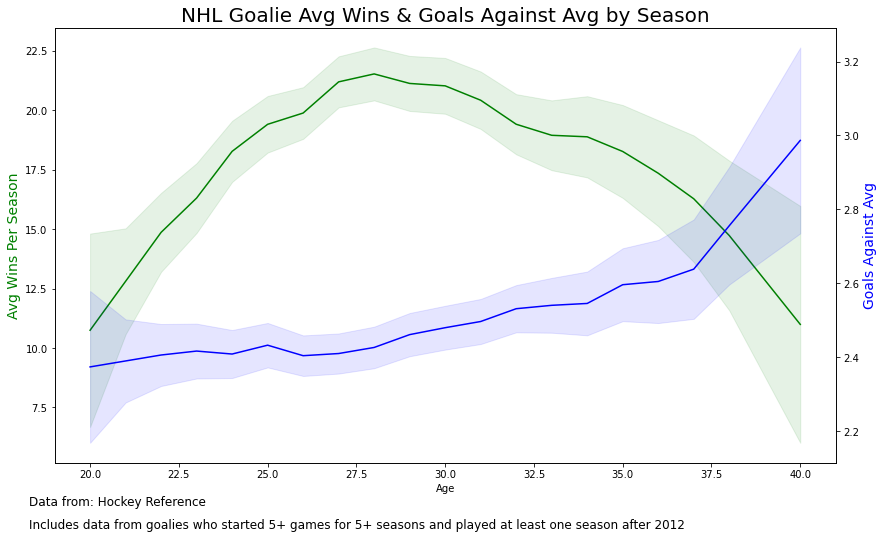

In [8]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter

# Mean values 
x = df_age['age']
avg_wins_x = df_age['avg_wins'].values.flatten()
goals_against_avg_x = df_age['goals_against_avg'].values.flatten()

# Smoothed Values
avg_wins = savgol_filter(avg_wins_x, 5, 1)
goals_against_avg = savgol_filter(goals_against_avg_x, 5, 1)

# Confidence Intervals 
wins_ci_high = avg_wins + df_age['wins_ci'] 
wins_ci_low = avg_wins - df_age['wins_ci'] 

goals_against_avg_ci_high = goals_against_avg + df_age['goals_against_avg_ci']
goals_against_avg_ci_low = goals_against_avg - df_age['goals_against_avg_ci']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, avg_wins, color='g')
ax2.plot(x, goals_against_avg, color='b')
plt.title('NHL Goalie Avg Wins & Goals Against Avg by Season', fontsize=20)

ax1.set_xlabel('Age')
ax1.set_ylabel('Avg Wins Per Season', color='g', fontsize=14)
ax2.set_ylabel('Goals Against Avg', color='b', fontsize=14)
ax1.fill_between(x, wins_ci_low, wins_ci_high, color='g', alpha=.1)
ax2.fill_between(x, goals_against_avg_ci_low, goals_against_avg_ci_high, color='b', alpha=.1)
fig.set_size_inches(14, 8)
plt.figtext(0.1, 0.05, "Data from: Hockey Reference", ha="left", fontsize=12)
plt.figtext(0.1, 0.01, "Includes data from goalies who started 5+ games for 5+ seasons and played at least one season after 2012", ha="left", fontsize=12)

plt.show()


## Predictive Wins Model

In [241]:
df_data_for_model.head()

,player_name,season,team,age,games_goalie,starts_goalie_filled,wins_goalie_filled,losses_goalie_filled,ties_goalie_filled,goals_against_filled,shots_against_filled,saves_filled,save_pct_filled,goals_against_avg_filled,shutouts_filled,num_seasons
2,Darcy Kuemper,2013-14,MIN,23,26,25,12,8,4,60,702,642,0.915,2.43,2.0,9
3,Darcy Kuemper,2014-15,MIN,24,31,28,14,12,2,68,718,650,0.905,2.60,3.0,9
4,Darcy Kuemper,2015-16,MIN,25,21,16,6,7,5,43,507,464,0.915,2.43,2.0,9
5,Darcy Kuemper,2016-17,MIN,26,18,17,8,5,3,55,562,507,0.902,3.13,0.0,9
6,Darcy Kuemper,2017-18,TOT,27,29,25,12,7,5,67,833,766,0.920,2.52,4.0,9


### Generating features - data from the 3 previous seasons for each goalie 

1. Age at time of season 
2. Avg wins previous 3 seasons 
3. Wins last season 
4. Goals against avg from previous 3 seasons 
5. Goals against avg from last season 
6. Save pct from 3 previous seasons 
7. Save pct from last season 

In [444]:
df_model_data = df_data_for_model[['player_name'
                                  ,'season'
                                  ,'age'
                                  ,'wins_goalie_filled']]

df_data_from_prev_seasons = df_data_for_model[['player_name'
                                              ,'age'
                                              ,'wins_goalie_filled'
                                              ,'games_goalie'
                                              ,'goals_against_filled'
                                              ,'shots_against_filled']]

# Previous Season Data 
df_data_from_last_season = df_data_from_prev_seasons.copy()
df_data_from_last_season['age_next_season'] = df_data_from_last_season['age'] + 1
prev_seasons = 1 
df_data_from_last_season.rename(columns={'wins_goalie_filled': 'wins_{0}'.format(prev_seasons)
                                         , 'games_goalie': 'games_{0}'.format(prev_seasons)
                                         , 'goals_against_filled': 'goals_against_{0}'.format(prev_seasons)  
                                         , 'shots_against_filled': 'shots_against_{0}'.format(prev_seasons) 
                                         , 'age': 'age_{}'.format(prev_seasons)
                                        },inplace=True)

# Data from 2 seasons agp 
df_data_from_last_2_season = df_data_from_prev_seasons.copy()
df_data_from_last_2_season['age_next_2_season'] = df_data_from_last_2_season['age'] + 2
prev_seasons = 2 
df_data_from_last_2_season.rename(columns={'wins_goalie_filled': 'wins_{0}'.format(prev_seasons)
                                         , 'games_goalie': 'games_{0}'.format(prev_seasons)
                                         , 'goals_against_filled': 'goals_against_{0}'.format(prev_seasons)  
                                         , 'shots_against_filled': 'shots_against_{0}'.format(prev_seasons) 
                                         , 'age': 'age_{}'.format(prev_seasons)
                                        },inplace=True)

# Data from 3 seasons agp 
df_data_from_last_3_season = df_data_from_prev_seasons.copy()
df_data_from_last_3_season['age_next_3_season'] = df_data_from_last_3_season['age'] + 3
prev_seasons = 3 
df_data_from_last_3_season.rename(columns={'wins_goalie_filled': 'wins_{0}'.format(prev_seasons)
                                         , 'games_goalie': 'games_{0}'.format(prev_seasons)
                                         , 'goals_against_filled': 'goals_against_{0}'.format(prev_seasons)  
                                         , 'shots_against_filled': 'shots_against_{0}'.format(prev_seasons) 
                                         , 'age': 'age_{}'.format(prev_seasons)
                                        },inplace=True)

# Merged Dataframe 
df_model_data = df_model_data.merge(df_data_from_last_season
                                   ,left_on=['age','player_name']
                                   ,right_on=['age_next_season','player_name']
                                   ,how='left')
df_model_data = df_model_data.merge(df_data_from_last_2_season
                                   ,left_on=['age','player_name']
                                   ,right_on=['age_next_2_season','player_name']
                                   ,how='left')
df_model_data = df_model_data.merge(df_data_from_last_3_season
                                   ,left_on=['age','player_name']
                                   ,right_on=['age_next_3_season','player_name']
                                   ,how='left')



def prev_3_seasons_check(x,y,z):
    if x > 1 and y > 1 and z > 1:
        return 1 
    else: 
        return 0 
    
def prev_season_check(x):
    if x > 1:
        return 1 
    else: 
        return 0 
    

df_model_data['3_prev_seasons'] = df_model_data.apply(lambda x: prev_3_seasons_check(x['games_1'],x['games_2'],x['games_3']),axis=1)
df_model_data['1_prev_seasons'] = df_model_data.apply(lambda x: prev_season_check(x['games_1']),axis=1)
df_model_data_good_seasons = df_model_data.copy()
num_seasons = len(df_model_data_good_seasons)
print('Number of seasons for model: {0}'.format(num_seasons))


Number of seasons for model: 462


In [445]:
df_model_data_good_seasons.head()

def three_season_avg(x,y,z):
    return (x + y + z) / 3 

df_model_data_good_seasons['avg_wins_3_seasons'] = df_model_data_good_seasons.apply(lambda x: three_season_avg(x['wins_1'],x['wins_2'],x['wins_3']),axis=1)
df_model_data_good_seasons['wins_last_season'] = df_model_data_good_seasons['wins_1']

df_model_data_good_seasons['goals_against_avg_3_seasons'] = (df_model_data_good_seasons['goals_against_1'] + df_model_data_good_seasons['goals_against_2'] + df_model_data_good_seasons['goals_against_3']) / (df_model_data_good_seasons['games_1'] + df_model_data_good_seasons['games_2'] + df_model_data_good_seasons['games_3'])
df_model_data_good_seasons['goals_against_avg_last_season'] = df_model_data_good_seasons['goals_against_1'] / df_model_data_good_seasons['games_1'] 

df_model_data_good_seasons['save_pct_avg_3_seasons'] = ((df_model_data_good_seasons['shots_against_1'] + df_model_data_good_seasons['shots_against_2'] + df_model_data_good_seasons['shots_against_3']) - (df_model_data_good_seasons['goals_against_1'] + df_model_data_good_seasons['goals_against_2'] + df_model_data_good_seasons['goals_against_3'])) / (df_model_data_good_seasons['shots_against_1'] + df_model_data_good_seasons['shots_against_2'] + df_model_data_good_seasons['shots_against_3'])
df_model_data_good_seasons['save_pct_last_season'] = (df_model_data_good_seasons['shots_against_1'] - df_model_data_good_seasons['goals_against_1'] )/ df_model_data_good_seasons['shots_against_1'] 


df_model_data_good_seasons.head()


,player_name,season,age,wins_goalie_filled,age_1,wins_1,games_1,goals_against_1,shots_against_1,age_next_season,age_2,wins_2,games_2,goals_against_2,shots_against_2,age_next_2_season,age_3,wins_3,games_3,goals_against_3,shots_against_3,age_next_3_season,3_prev_seasons,1_prev_seasons,avg_wins_3_seasons,wins_last_season,goals_against_avg_3_seasons,goals_against_avg_last_season,save_pct_avg_3_seasons,save_pct_last_season
0,Darcy Kuemper,2013-14,23,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Darcy Kuemper,2014-15,24,14,23.0,12.0,26.0,60.0,702.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,12.0,NaN,2.307692,NaN,0.914530
2,Darcy Kuemper,2015-16,25,6,24.0,14.0,31.0,68.0,718.0,25.0,23.0,12.0,26.0,60.0,702.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,14.0,NaN,2.193548,NaN,0.905292
3,Darcy Kuemper,2016-17,26,8,25.0,6.0,21.0,43.0,507.0,26.0,24.0,14.0,31.0,68.0,718.0,26.0,23.0,12.0,26.0,60.0,702.0,26.0,1,1,10.666667,6.0,2.192308,2.047619,0.911261,0.915187
4,Darcy Kuemper,2017-18,27,12,26.0,8.0,18.0,55.0,562.0,27.0,25.0,6.0,21.0,43.0,507.0,27.0,24.0,14.0,31.0,68.0,718.0,27.0,1,1,9.333333,8.0,2.371429,3.055556,0.907107,0.902135


In [446]:
features = df_model_data_good_seasons[['age'
                                        ,'avg_wins_3_seasons'
                                        ,'wins_last_season'
                                        ,'goals_against_avg_3_seasons'
                                        ,'goals_against_avg_last_season'
                                        ,'save_pct_avg_3_seasons'
                                        ,'save_pct_last_season'
                                        ]].reset_index()
features = features[['age'
                                        ,'avg_wins_3_seasons'
                                        ,'wins_last_season'
                                        ,'goals_against_avg_3_seasons'
                                        ,'goals_against_avg_last_season'
                                        ,'save_pct_avg_3_seasons'
                                        ,'save_pct_last_season'
                                        ]]
features.head()

# Features no age 

features_no_age = df_model_data_good_seasons[['avg_wins_3_seasons'
                                        ,'wins_last_season'
                                        ,'goals_against_avg_3_seasons'
                                        ,'goals_against_avg_last_season'
                                        ,'save_pct_avg_3_seasons'
                                        ,'save_pct_last_season'
                                        ]].reset_index()
features_no_age = features_no_age[['avg_wins_3_seasons'
                                        ,'wins_last_season'
                                        ,'goals_against_avg_3_seasons'
                                        ,'goals_against_avg_last_season'
                                        ,'save_pct_avg_3_seasons'
                                        ,'save_pct_last_season'
                                        ]]
features_no_age.head()

,avg_wins_3_seasons,wins_last_season,goals_against_avg_3_seasons,goals_against_avg_last_season,save_pct_avg_3_seasons,save_pct_last_season
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,12.0,NaN,2.307692,NaN,0.914530
2,NaN,14.0,NaN,2.193548,NaN,0.905292
3,10.666667,6.0,2.192308,2.047619,0.911261,0.915187
4,9.333333,8.0,2.371429,3.055556,0.907107,0.902135


In [447]:
outcomes = df_model_data_good_seasons[['wins_goalie_filled'
                                        ]].reset_index()
outcomes = outcomes[['wins_goalie_filled']]
outcomes.head()

,wins_goalie_filled
0,12
1,14
2,6
3,8
4,12


## Building Model

In [448]:
seed = 7
test_size = 0.50
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=test_size, random_state=seed)
X_train_no_age, X_test_no_age, y_train_no_age, y_test_no_age = train_test_split(features_no_age, outcomes, test_size=test_size, random_state=seed)


In [449]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
model = XGBClassifier(max_depth=1,gamma=1)
model.fit(X_train, y_train)

# No age feature 
y_train_no_age = le.fit_transform(y_train_no_age)
model_no_age = XGBClassifier(max_depth=1,gamma=1)
model_no_age.fit(X_train_no_age, y_train_no_age)

/Users/benjaminmoore/instacart/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [450]:
wins_pred = model.predict(X_test)
wins_pred_no_age = model_no_age.predict(X_test_no_age)

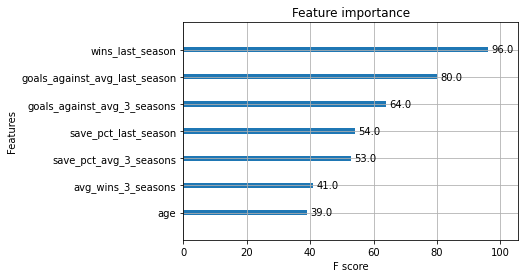

In [451]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
pyplot.show()

### Reviewing outcomes

In [452]:
df_with_predictions_test_only = X_test.copy()
predictions = model.predict(X_test)
predictions_no_age = model_no_age.predict(X_test_no_age)

df_with_predictions_test_only['predictions'] = predictions
df_with_predictions_test_only['predictions_without_age_feature'] = predictions_no_age 
df_with_predictions_test_only['actual_wins'] = y_test 
df_with_predictions_test_only['prediction_delta'] = df_with_predictions_test_only['predictions'] - df_with_predictions_test_only['actual_wins']
df_with_predictions_test_only['prediction_delta_no_age_feature'] = df_with_predictions_test_only['predictions_without_age_feature'] - df_with_predictions_test_only['actual_wins']

df_with_predictions_test_only.head(5)



,age,avg_wins_3_seasons,wins_last_season,goals_against_avg_3_seasons,goals_against_avg_last_season,save_pct_avg_3_seasons,save_pct_last_season,predictions,predictions_without_age_feature,actual_wins,prediction_delta,prediction_delta_no_age_feature
13,27,36.000000,36.0,2.438144,2.200000,0.911820,0.917910,33,33,42,-9,-9
459,33,15.666667,10.0,2.258621,1.884615,0.912783,0.927407,19,31,22,-3,9
89,22,NaN,NaN,NaN,NaN,NaN,NaN,3,7,2,1,5
347,26,NaN,1.0,NaN,2.214286,NaN,0.889286,21,9,8,13,1
236,27,26.666667,28.0,2.483871,2.473684,0.919975,0.921273,22,17,27,-5,-10


In [453]:
df_prediction_error = df_with_predictions_test_only.groupby('prediction_delta').agg(num_goalie_seasons=('predictions','count')).reset_index()
df_prediction_error['pct_of_predictions'] = df_prediction_error['num_goalie_seasons'] / df_prediction_error['num_goalie_seasons'].sum()

df_prediction_error_no_age_feature = df_with_predictions_test_only.groupby('prediction_delta_no_age_feature').agg(num_goalie_seasons=('predictions','count')).reset_index()
df_prediction_error_no_age_feature['pct_of_predictions'] = df_prediction_error_no_age_feature['num_goalie_seasons'] / df_prediction_error_no_age_feature['num_goalie_seasons'].sum()
df_prediction_error_no_age_feature.head(5)


,prediction_delta_no_age_feature,num_goalie_seasons,pct_of_predictions
0,-32,2,0.008658
1,-30,3,0.012987
2,-29,2,0.008658
3,-28,3,0.012987
4,-26,1,0.004329


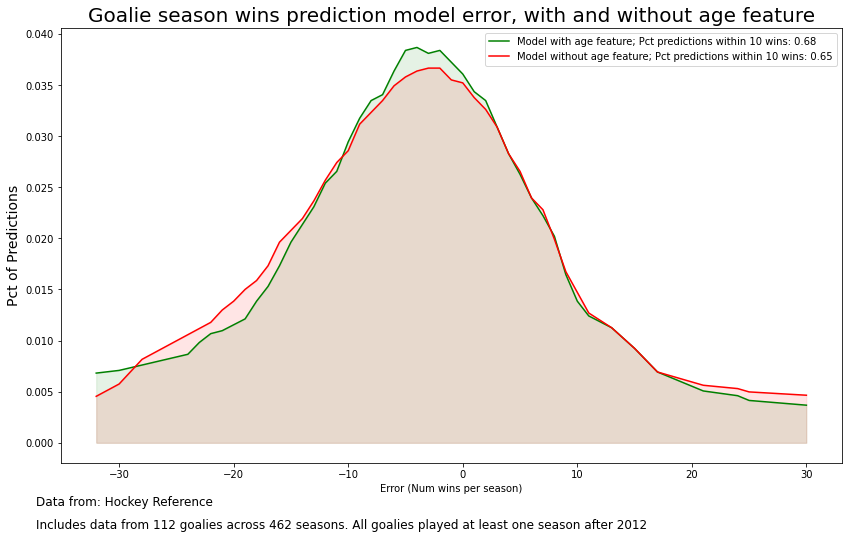

In [457]:
x_no_age = df_prediction_error_no_age_feature['prediction_delta_no_age_feature']
x_age = df_prediction_error['prediction_delta']
predictions = df_prediction_error['pct_of_predictions']  
predictions_without_age_feature = df_prediction_error_no_age_feature['pct_of_predictions'] 

# Smoothed Values
predictions = savgol_filter(predictions, 15, 1)
predictions_without_age_feature = savgol_filter(predictions_without_age_feature, 15, 1)

num_wins_var = 10 

pred_5_wins_pct = np.round(df_prediction_error.loc[(df_prediction_error['prediction_delta']<= num_wins_var) & (df_prediction_error['prediction_delta']>= (-1 *num_wins_var))]['pct_of_predictions'].sum(),2)
pred_no_age_5_wins_pct = np.round(df_prediction_error_no_age_feature.loc[(df_prediction_error_no_age_feature['prediction_delta_no_age_feature']<= num_wins_var) & (df_prediction_error_no_age_feature['prediction_delta_no_age_feature']>= (-1*num_wins_var))]['pct_of_predictions'].sum(),2)

fig, ax1 = plt.subplots()

ax1.plot(x_age, predictions, color='g',label='Model with age feature; Pct predictions within {1} wins: {0}'.format(pred_5_wins_pct,num_wins_var))
ax1.plot(x_no_age, predictions_without_age_feature, color='r',label='Model without age feature; Pct predictions within {1} wins: {0}'.format(pred_no_age_5_wins_pct,num_wins_var))
ax1.fill_between(x_age, 0, predictions, color='g', alpha=.1)
ax1.fill_between(x_no_age, 0, predictions_without_age_feature, color='r', alpha=.1)
plt.title('Goalie season wins prediction model error, with and without age feature', fontsize=20)

ax1.set_xlabel('Error (Num wins per season)')
ax1.set_ylabel('Pct of Predictions', fontsize=14)
fig.set_size_inches(14, 8)
plt.figtext(0.1, 0.05, "Data from: Hockey Reference", ha="left", fontsize=12)
plt.figtext(0.1, 0.01, "Includes data from 112 goalies across 462 seasons. All goalies played at least one season after 2012", ha="left", fontsize=12)
plt.legend()
# plt.xlim(-30, 30)

plt.show()